In [1]:
import pandas as pd

# Load the data
traffic_data = pd.read_csv('traffic.csv')

# Convert 'DateTime' column to datetime objects
traffic_data['DateTime'] = pd.to_datetime(traffic_data['DateTime'])

# Set 'DateTime' as the index of the DataFrame
traffic_data = traffic_data.set_index('DateTime')


# Filter data for Junction 1
traffic_data_junction1 = traffic_data[traffic_data['Junction'] == 1]

# Train-test split
train_data = traffic_data_junction1['2015-11-01':'2016-12-14']
test_data = traffic_data_junction1['2016-12-15':'2017-01-30']

print(traffic_data.head())
print(traffic_data.index)  # Should show DatetimeIndex


# Verify the splits
print("Training Data Info:")
print(train_data.info())
print("Testing Data Info:")
print(test_data.info())

                     Junction  Vehicles           ID
DateTime                                            
2015-11-01 00:00:00         1        15  20151101001
2015-11-01 01:00:00         1        13  20151101011
2015-11-01 02:00:00         1        10  20151101021
2015-11-01 03:00:00         1         7  20151101031
2015-11-01 04:00:00         1         9  20151101041
DatetimeIndex(['2015-11-01 00:00:00', '2015-11-01 01:00:00',
               '2015-11-01 02:00:00', '2015-11-01 03:00:00',
               '2015-11-01 04:00:00', '2015-11-01 05:00:00',
               '2015-11-01 06:00:00', '2015-11-01 07:00:00',
               '2015-11-01 08:00:00', '2015-11-01 09:00:00',
               ...
               '2017-06-30 14:00:00', '2017-06-30 15:00:00',
               '2017-06-30 16:00:00', '2017-06-30 17:00:00',
               '2017-06-30 18:00:00', '2017-06-30 19:00:00',
               '2017-06-30 20:00:00', '2017-06-30 21:00:00',
               '2017-06-30 22:00:00', '2017-06-30 23:00:00'],

In [2]:
# Find the earliest and latest timestamps in the index
min_date = traffic_data.index.min()
max_date = traffic_data.index.max()

print("Earliest date:", min_date)
print("Latest date:", max_date)


Earliest date: 2015-11-01 00:00:00
Latest date: 2017-06-30 23:00:00


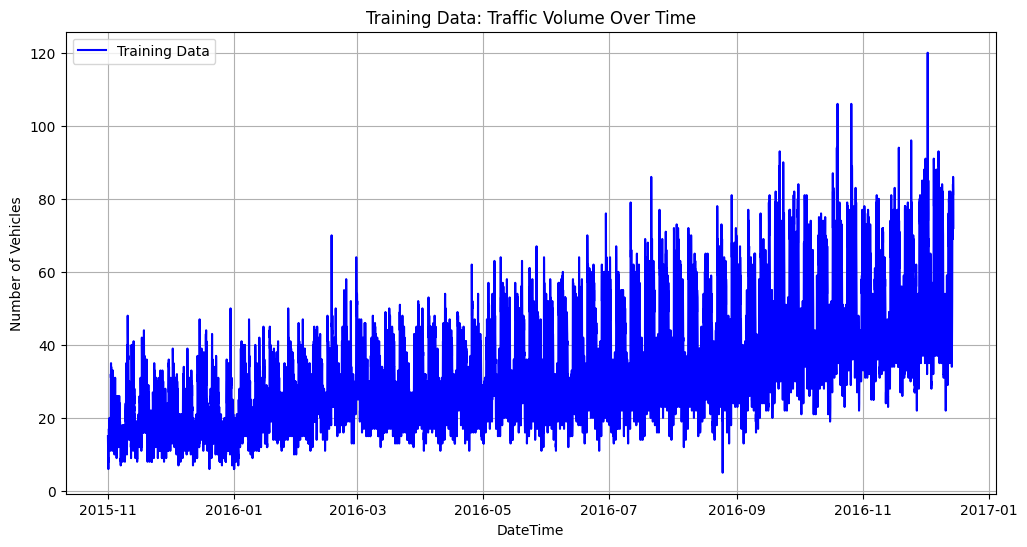

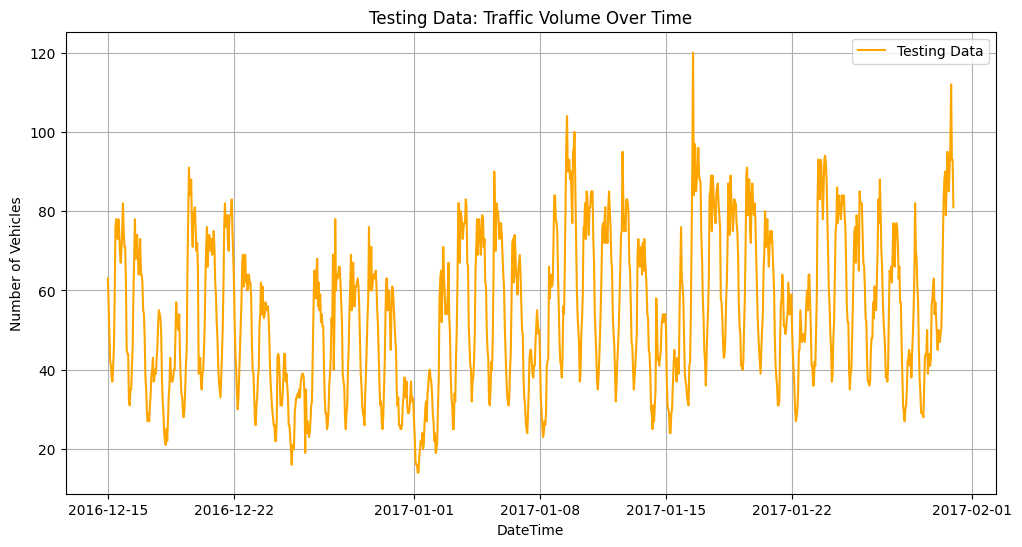

In [3]:
import matplotlib.pyplot as plt

# Plot training data
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data['Vehicles'], label='Training Data', color='blue')
plt.title('Training Data: Traffic Volume Over Time')
plt.xlabel('DateTime')
plt.ylabel('Number of Vehicles')
plt.legend()
plt.grid(True)
plt.show()

# Plot testing data
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data['Vehicles'], label='Testing Data', color='orange')
plt.title('Testing Data: Traffic Volume Over Time')
plt.xlabel('DateTime')
plt.ylabel('Number of Vehicles')
plt.legend()
plt.grid(True)
plt.show()


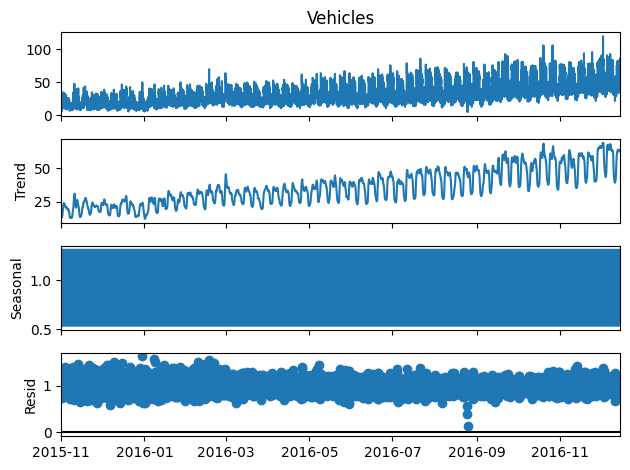

In [4]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose training data
result = seasonal_decompose(train_data['Vehicles'], model='multiplicative', period=24)
result.plot()
plt.show()


In [5]:
from statsmodels.tsa.stattools import adfuller

# Perform the Dickey-Fuller test on the training data
adf_test = adfuller(train_data['Vehicles'])

# Print the results
print("ADF Statistic:", adf_test[0])
print("p-value:", adf_test[1])
print("Critical Values:")
for key, value in adf_test[4].items():
    print(f"   {key}: {value}")


ADF Statistic: -6.724172068913759
p-value: 3.4229157782397045e-09
Critical Values:
   1%: -3.4310172460634023
   5%: -2.8618348824161233
   10%: -2.5669269607818967


In [6]:
# Difference the data
# Calculate differenced data and handle NaNs properly
train_data['Vehicles_diff'] = train_data['Vehicles'].diff()

# Drop NaN values after differencing
train_data_diff = train_data.dropna(subset=['Vehicles_diff']).copy()

/var/folders/5v/0k23dsln37jgc1ddl5m66jxm0000gn/T/ipykernel_14808/3813788973.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['Vehicles_diff'] = train_data['Vehicles'].diff()


In [7]:

from statsmodels.tsa.stattools import adfuller

# Perform ADF test on the differenced data
adf_test_diff = adfuller(train_data_diff['Vehicles_diff'])

# Print results
print("ADF Statistic (Differenced):", adf_test_diff[0])
print("p-value (Differenced):", adf_test_diff[1])
print("Critical Values (Differenced):")
for key, value in adf_test_diff[4].items():
    print(f"   {key}: {value}")



ADF Statistic (Differenced): -18.55040438943159
p-value (Differenced): 2.092755739209168e-30
Critical Values (Differenced):
   1%: -3.431017450375941
   5%: -2.8618349726997683
   10%: -2.5669270088400666


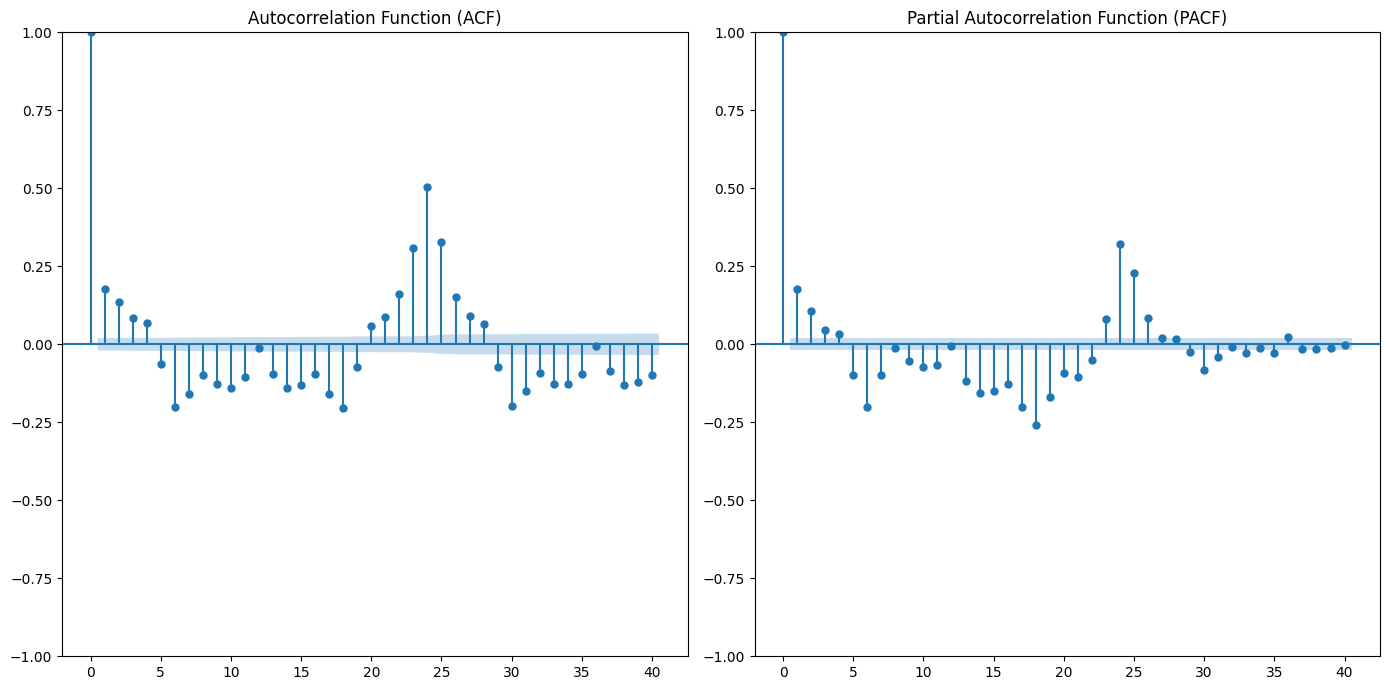

In [30]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Plot ACF and PACF for differenced data
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

plot_acf(train_data_diff['Vehicles_diff'], lags=40, ax=axes[0])
axes[0].set_title("Autocorrelation Function (ACF)")

plot_pacf(train_data_diff['Vehicles_diff'], lags=40, ax=axes[1], method='ywm')
axes[1].set_title("Partial Autocorrelation Function (PACF)")

plt.tight_layout()
plt.show()


In [26]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Define SARIMA parameters
p, d, q = 2, 1, 1  # Non-seasonal parameters
P, D, Q, m = 2, 1, 1, 24  # Seasonal parameters (24 for daily seasonality in hourly data)

# Fit the SARIMA model
sarima_model = SARIMAX(train_data['Vehicles'],
                       order=(p, d, q),
                       seasonal_order=(P, D, Q, m),
                       enforce_stationarity=False,
                       enforce_invertibility=False)
sarima_results = sarima_model.fit()

# Display model summary
print(sarima_results.summary())


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.84205D+00    |proj g|=  7.16593D-02


 This problem is unconstrained.


  ys=-6.214E-02  -gs= 8.690E-02 BFGS update SKIPPED

At iterate    5    f=  2.72949D+00    |proj g|=  8.11043D-02

At iterate   10    f=  2.69777D+00    |proj g|=  9.26555D-03

At iterate   15    f=  2.69766D+00    |proj g|=  1.81569D-02

At iterate   20    f=  2.69757D+00    |proj g|=  7.92726D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     22     31      1     1     0   1.204D-05   2.698D+00
  F =   2.6975735615124976     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                                     SARIMAX Results                                      
Dep. Variable:                  

In [27]:
# Forecast for the test period
forecast_steps = len(test_data)
forecast = sarima_results.get_forecast(steps=forecast_steps)

# Extract forecasted values
forecast_mean = forecast.predicted_mean
forecast_mean.index = test_data.index

# Extract confidence intervals
forecast_conf_int = forecast.conf_int()
forecast_conf_int.index = test_data.index

# Compare actual vs predicted
comparison_df = pd.DataFrame({
    'Actual': test_data['Vehicles'],
    'Predicted': forecast_mean
})
print("Comparison (Actual vs Predicted):")
print(comparison_df.head())


Comparison (Actual vs Predicted):
                     Actual  Predicted
DateTime                              
2016-12-15 00:00:00      63  68.346502
2016-12-15 01:00:00      56  61.848459
2016-12-15 02:00:00      49  56.754400
2016-12-15 03:00:00      42  52.280866
2016-12-15 04:00:00      41  46.737478


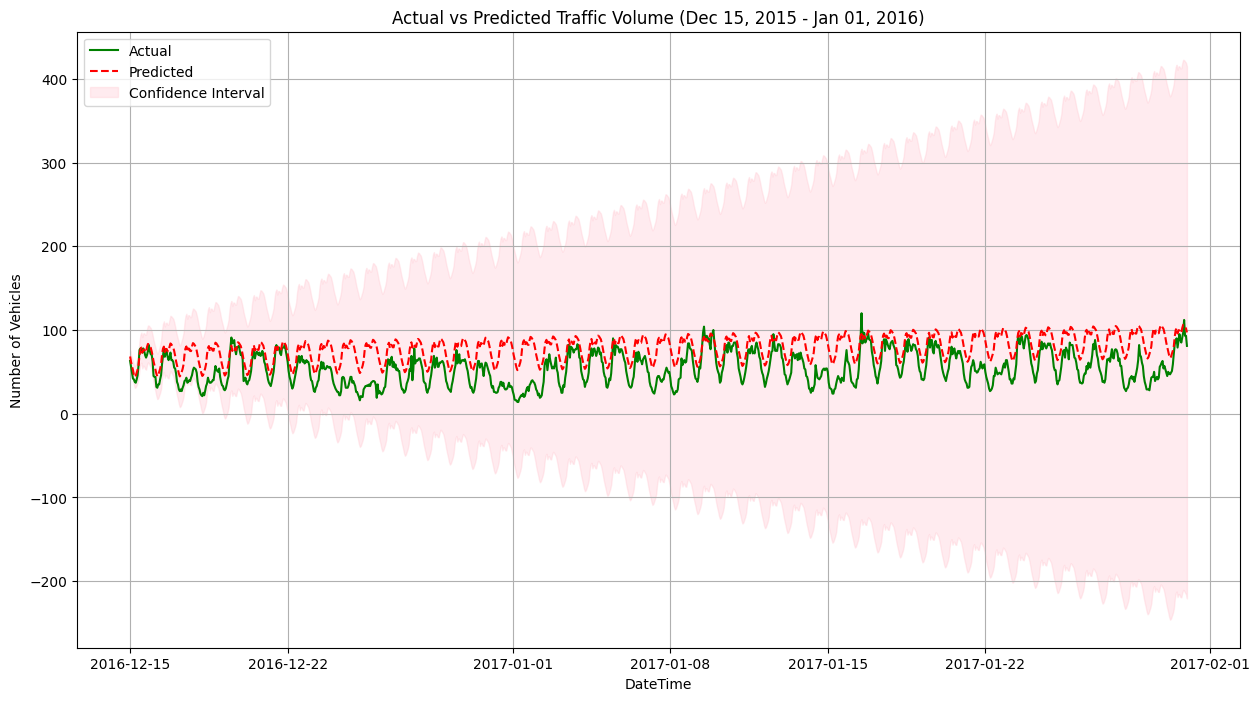

In [28]:
import matplotlib.pyplot as plt

# Plot actual vs predicted traffic volumes
plt.figure(figsize=(15, 8))
plt.plot(test_data.index, test_data['Vehicles'], label='Actual', color='green')
plt.plot(forecast_mean.index, forecast_mean, label='Predicted', color='red', linestyle='--')
plt.fill_between(forecast_mean.index,
                 forecast_conf_int.iloc[:, 0],
                 forecast_conf_int.iloc[:, 1],
                 color='pink', alpha=0.3, label='Confidence Interval')
plt.title('Actual vs Predicted Traffic Volume (Dec 15, 2015 - Jan 01, 2016)')
plt.xlabel('DateTime')
plt.ylabel('Number of Vehicles')
plt.legend()
plt.grid(True)
plt.show()

In [29]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(test_data['Vehicles'], forecast_mean)
rmse = np.sqrt(mean_squared_error(test_data['Vehicles'], forecast_mean))

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")


Mean Absolute Error (MAE): 24.47
Root Mean Squared Error (RMSE): 27.72
